**get model coordinates**

In [1]:
import plotly.express as px
import pandas as pd
import numpy as np

coor = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/met_ model/distan_lat42.58lon-8.8046p3R4Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

**Coron**

In [2]:
pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/station_data/coron.csv").set_index("time").info()

<class 'pandas.core.frame.DataFrame'>
Index: 262224 entries, 2018-01-01 00:10:00 to 2022-12-31 00:00:00
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   dir_o    259014 non-null  float64
 1   spd_o    259017 non-null  float64
 2   gust_o   259017 non-null  float64
 3   sddir_o  259014 non-null  float64
 4   sdspd_o  259017 non-null  float64
dtypes: float64(5)
memory usage: 12.0+ MB


**Cortegada**

In [15]:
pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/station_data/cortegada.csv").set_index("time").info()

<class 'pandas.core.frame.DataFrame'>
Index: 260064 entries, 2018-01-01 00:10:00 to 2022-12-31 00:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   spd_o   258916 non-null  float64
 1   gust_o  258772 non-null  float64
 2   dir_o   258774 non-null  float64
dtypes: float64(3)
memory usage: 7.9+ MB


**Wind direction climatology new and old mean value**

**Cortegada**

               dir_o
count  258774.000000
mean      119.414990
std        96.330559
min         0.000000
25%        36.000000
50%        63.000000
75%       198.000000
max       360.000000


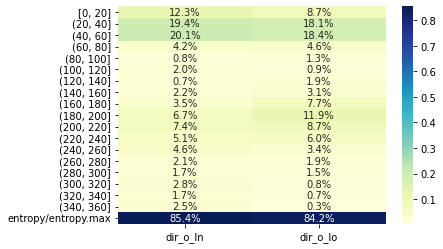

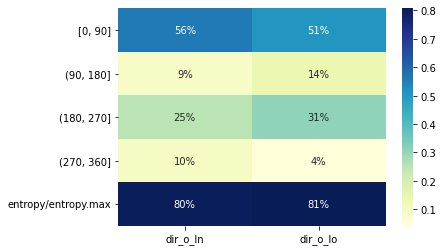

In [78]:
from pandas.core.arrays import categorical
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
import math

def average_wind_direction(directions):
    if len(directions) == 0:
        return float('nan')
    total = 0
    for direction in directions:
        direction = direction % 360
        if direction > 180:
            direction = direction - 360
        total += direction
    average = total / len(directions)
    if average < 0:
        average = average + 360
    return average



station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/station_data/cortegada.csv", usecols = ["time","dir_o"],parse_dates=["time"]).set_index("time")
print(station.describe())

#show duplicated
df_duplicate = station[station.index.duplicated()]
#print("duplicated")
#print(df_duplicate)

#delete duplicated and resample
station = station[~station.index.duplicated(keep='first')]

#reample with mean and new function
station_n = station.resample("H",label="right",closed="right").agg({'dir_o': average_wind_direction})
station_o = station.resample("H",label="right",closed="right").mean()

#label
#dir udr to interval
interval=pd.IntervalIndex.from_tuples([(-0.5,20), (20, 40), (40, 60),
                                       (60,80),(80,100),(100,120),(120,140),(140,160),
                                       (160,180),(180,200),(200,220),(220,240),
                                       (240,260),(260,280),(280,300),(300,320),
                                       (320,340),(340,360)])
labels=['[0, 20]', '(20, 40]', '(40, 60]','(60, 80]', '(80, 100]', '(100, 120]',
        '(120, 140]','(140, 160]', '(160, 180]', '(180, 200]', '(200, 220]',
        '(220, 240]', '(240, 260]', '(260, 280]', '(280, 300]','(300, 320]',
        '(320, 340]', '(340, 360]']

#show new function        
station_n["dir_o_ln"] = pd.cut(station_n["dir_o"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
#station_n = station_n.drop(["dir_o"],axis=1)


#show mean function
station_o["dir_o_lo"] = pd.cut(station_o["dir_o"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
#station_o = station_o.drop(["dir_o"],axis=1)

df_c = pd.concat([station_n,station_o],axis=1)

clim_n = df_c["dir_o_ln"].value_counts(normalize=True)
clim_o = df_c["dir_o_lo"].value_counts(normalize=True)
df_r = pd.concat([clim_n,clim_o],axis=1)
df_r = df_r.append(pd.DataFrame(entropy(df_r,base=2)/(math.log2(df_r.shape[0])),columns=["entropy/entropy.max"],
                    index=df_r.columns).T)

fig1 = sns.heatmap(df_r,annot=True,cmap="YlGnBu",fmt='.1%')
plt.show(fig1)

#new intervals
interval = pd.IntervalIndex.from_tuples([(-0.5,90), (90,180),(180,270),(270,360)])
labels = ['[0, 90]','(90, 180]','(180, 270]','(270, 360]']


#show new function        
station_n["dir_o_ln"] = pd.cut(station_n["dir_o"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
station_n = station_n.drop(["dir_o"],axis=1)


#show mean function
station_o["dir_o_lo"] = pd.cut(station_o["dir_o"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
station_o = station_o.drop(["dir_o"],axis=1)

df_c = pd.concat([station_n,station_o],axis=1)

clim_n = df_c["dir_o_ln"].value_counts(normalize=True)
clim_o = df_c["dir_o_lo"].value_counts(normalize=True)
df_r = pd.concat([clim_n,clim_o],axis=1)
df_r = df_r.append(pd.DataFrame(entropy(df_r,base=2)/(math.log2(df_r.shape[0])),columns=["entropy/entropy.max"],
                    index=df_r.columns).T)

fig2 = sns.heatmap(df_r,annot=True,cmap="YlGnBu",fmt='.0%');
plt.show(fig2)

**Coron**

               dir_o
count  259014.000000
mean      140.262538
std        97.846537
min         0.000000
25%        46.000000
50%       149.000000
75%       217.000000
max       360.000000


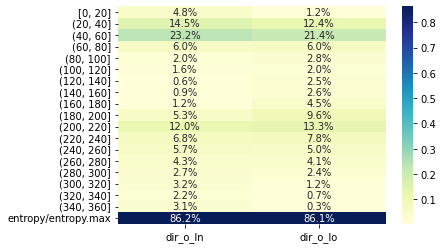

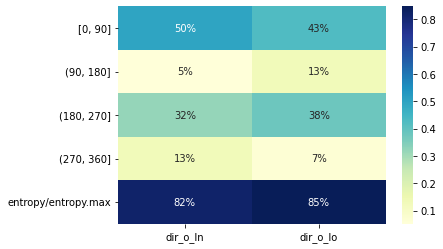

In [71]:
station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/station_data/coron.csv", usecols = ["time","dir_o"],parse_dates=["time"]).set_index("time")
print(station.describe())

#show duplicated
df_duplicate = station[station.index.duplicated()]
#print("duplicated")
#print(df_duplicate)

#delete duplicated and resample
station = station[~station.index.duplicated(keep='first')]

#reample with mean and new function
station_n = station.resample("H",label="right",closed="right").agg({'dir_o': average_wind_direction})
station_o = station.resample("H",label="right",closed="right").mean()

#label
#dir udr to interval
interval=pd.IntervalIndex.from_tuples([(-0.5,20), (20, 40), (40, 60),
                                       (60,80),(80,100),(100,120),(120,140),(140,160),
                                       (160,180),(180,200),(200,220),(220,240),
                                       (240,260),(260,280),(280,300),(300,320),
                                       (320,340),(340,360)])
labels=['[0, 20]', '(20, 40]', '(40, 60]','(60, 80]', '(80, 100]', '(100, 120]',
        '(120, 140]','(140, 160]', '(160, 180]', '(180, 200]', '(200, 220]',
        '(220, 240]', '(240, 260]', '(260, 280]', '(280, 300]','(300, 320]',
        '(320, 340]', '(340, 360]']

#show new function        
station_n["dir_o_ln"] = pd.cut(station_n["dir_o"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
#station_n = station_n.drop(["dir_o"],axis=1)


#show mean function
station_o["dir_o_lo"] = pd.cut(station_o["dir_o"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
#station_o = station_o.drop(["dir_o"],axis=1)

df_c = pd.concat([station_n,station_o],axis=1)

clim_n = df_c["dir_o_ln"].value_counts(normalize=True)
clim_o = df_c["dir_o_lo"].value_counts(normalize=True)
df_r = pd.concat([clim_n,clim_o],axis=1)
df_r = df_r.append(pd.DataFrame(entropy(df_r,base=2)/(math.log2(df_r.shape[0])),columns=["entropy/entropy.max"],
                    index=df_r.columns).T)

fig1 = sns.heatmap(df_r,annot=True,cmap="YlGnBu",fmt='.1%')
plt.show(fig1)

#new intervals
interval = pd.IntervalIndex.from_tuples([(-0.5,90), (90,180),(180,270),(270,360)])
labels = ['[0, 90]', '(90, 180]', '(180, 270]','(270, 360]']


#show new function        
station_n["dir_o_ln"] = pd.cut(station_n["dir_o"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
station_n = station_n.drop(["dir_o"],axis=1)


#show mean function
station_o["dir_o_lo"] = pd.cut(station_o["dir_o"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
station_o = station_o.drop(["dir_o"],axis=1)

df_c = pd.concat([station_n,station_o],axis=1)

clim_n = df_c["dir_o_ln"].value_counts(normalize=True)
clim_o = df_c["dir_o_lo"].value_counts(normalize=True)
df_r = pd.concat([clim_n,clim_o],axis=1)
df_r = df_r.append(pd.DataFrame(entropy(df_r,base=2)/(math.log2(df_r.shape[0])),columns=["entropy/entropy.max"],
                    index=df_r.columns).T)

fig2 = sns.heatmap(df_r,annot=True,cmap="YlGnBu",fmt='.0%');
plt.show(fig2)

**get meteorologic model d0**

In [79]:
#ria forecast d0
met_model = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/met_ model/lat42.58lon-8.8046p3R4KmD0.csv",parse_dates=["time"]).drop(columns=["Unnamed: 0"]).set_index("time")
met_model.drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42021 entries, 2018-01-01 01:00:00 to 2023-01-01 23:00:00
Data columns (total 75 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dir0         42021 non-null  float64
 1   snow_prec0   42021 non-null  float64
 2   snowlevel0   42021 non-null  float64
 3   mod0         42021 non-null  float64
 4   wind_gust0   42021 non-null  float64
 5   mslp0        42021 non-null  float64
 6   temp0        42021 non-null  float64
 7   rh0          42021 non-null  float64
 8   visibility0  42021 non-null  float64
 9   lhflx0       42021 non-null  float64
 10  lwflx0       42021 non-null  float64
 11  conv_prec0   42021 non-null  float64
 12  prec0        42021 non-null  float64
 13  swflx0       42021 non-null  float64
 14  shflx0       42021 non-null  float64
 15  cape0        42021 non-null  float64
 16  cin0         42021 non-null  float64
 17  cfh0         42021 non-null  float64
 18  cfl0       

**Old system**

In [39]:
station ["dir_o_l"] = station_o["dir_o_lo"]
station = station.drop(["dir_o"],axis=1)

**New system**

In [80]:
station ["dir_o_l"] = station_n["dir_o_ln"]
station = station.drop(["dir_o"],axis=1)

**Concatenate and dropnan**

In [81]:
df_all = pd.concat([station,met_model],axis=1).dropna()
df_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41319 entries, 2018-01-01 01:00:00 to 2022-12-30 23:00:00
Data columns (total 76 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   dir_o_l      41319 non-null  category
 1   dir0         41319 non-null  float64 
 2   snow_prec0   41319 non-null  float64 
 3   snowlevel0   41319 non-null  float64 
 4   mod0         41319 non-null  float64 
 5   wind_gust0   41319 non-null  float64 
 6   mslp0        41319 non-null  float64 
 7   temp0        41319 non-null  float64 
 8   rh0          41319 non-null  float64 
 9   visibility0  41319 non-null  float64 
 10  lhflx0       41319 non-null  float64 
 11  lwflx0       41319 non-null  float64 
 12  conv_prec0   41319 non-null  float64 
 13  prec0        41319 non-null  float64 
 14  swflx0       41319 non-null  float64 
 15  shflx0       41319 non-null  float64 
 16  cape0        41319 non-null  float64 
 17  cin0         41319 non-null  float

**Compare accuracy dir0, dir1, dir2 versus dir_o_l**

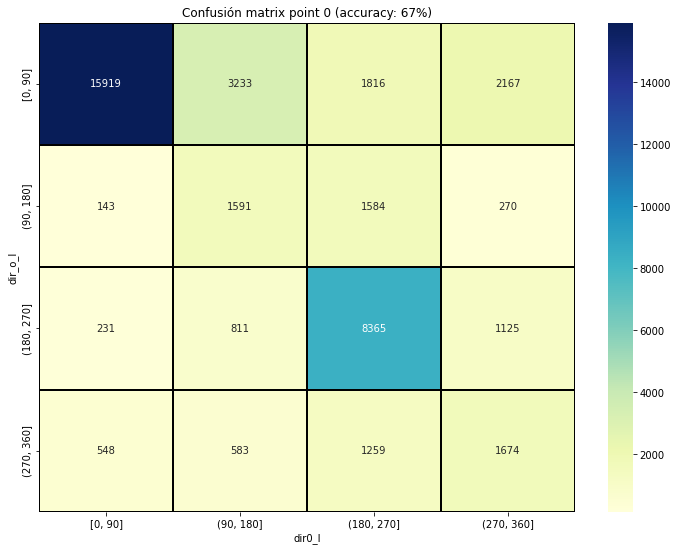

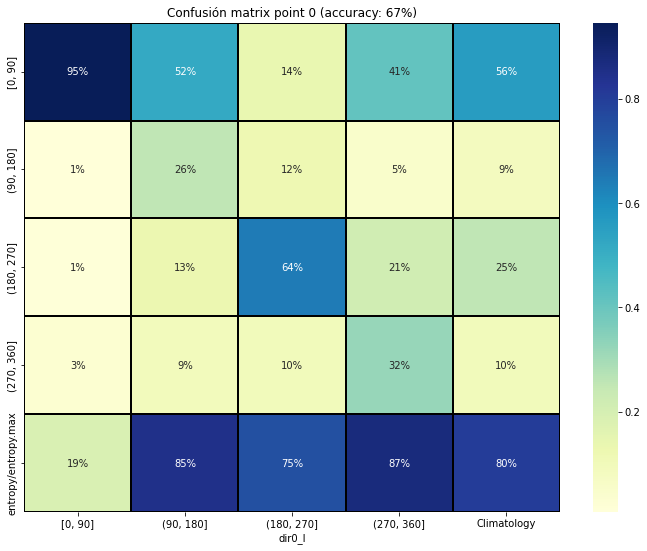

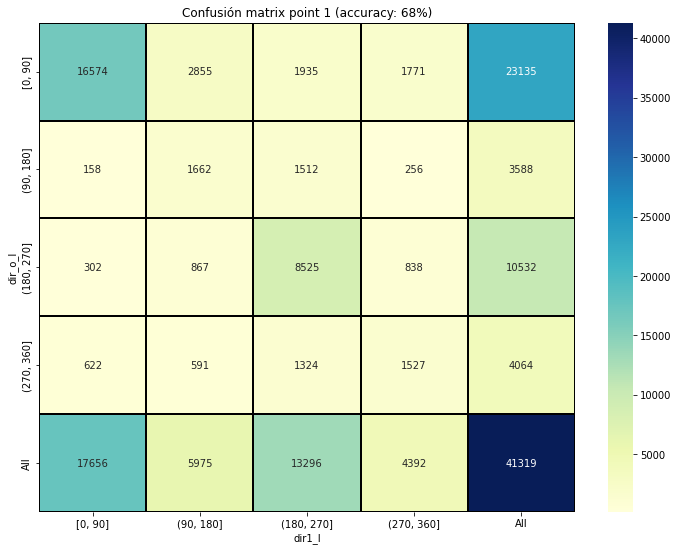

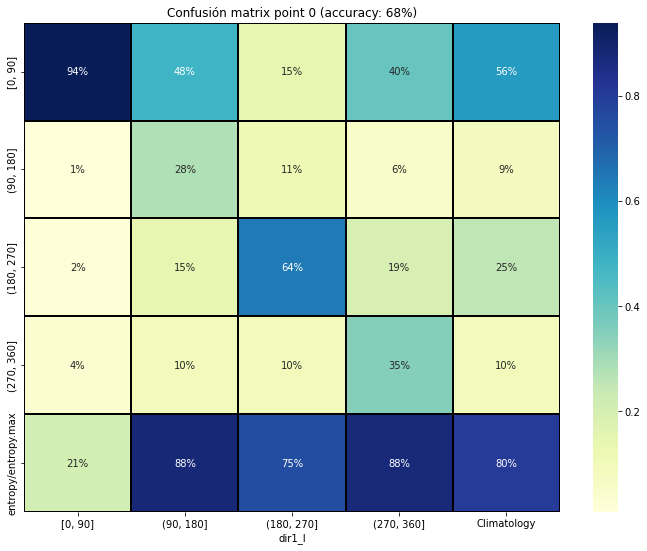

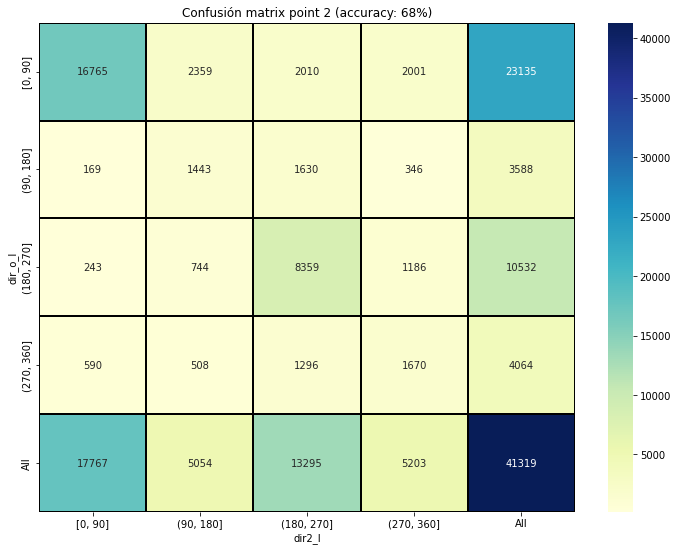

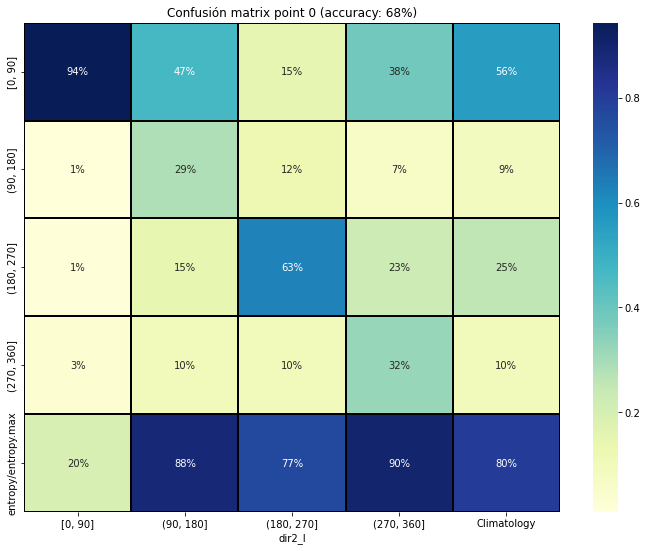

In [82]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import math
from scipy.stats import entropy
import seaborn as sns

#label dir 0,1 and 2
df_all["dir0_l"] = pd.cut(df_all["dir0"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
df_all["dir1_l"] = pd.cut(df_all["dir1"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
df_all["dir2_l"] = pd.cut(df_all["dir2"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')

acc0 = accuracy_score(df_all.dir_o_l, df_all.dir0_l)
acc1 = accuracy_score(df_all.dir_o_l, df_all.dir1_l)
acc2 = accuracy_score(df_all.dir_o_l, df_all.dir2_l)

#point 0
plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 0 (accuracy: {:.0%})".format(acc0))
global_sc = pd.crosstab(df_all.dir_o_l, df_all.dir0_l,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 0 (accuracy: {:.0%})".format(acc0))
column_sc = pd.crosstab(df_all.dir_o_l, df_all.dir0_l, margins=True,normalize="columns")
column_sc = column_sc.append(pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T).rename(columns={"All":"Climatology"})
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

#point1
plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 1 (accuracy: {:.0%})".format(acc1))
global_sc = pd.crosstab(df_all.dir_o_l, df_all.dir1_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 0 (accuracy: {:.0%})".format(acc1))
column_sc = pd.crosstab(df_all.dir_o_l, df_all.dir1_l, margins=True,normalize="columns")
column_sc = column_sc.append(pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                   index=column_sc.columns).T).rename(columns={"All":"Climatology"})
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');


#point2
plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 2 (accuracy: {:.0%})".format(acc2))
global_sc = pd.crosstab(df_all.dir_o_l, df_all.dir2_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 0 (accuracy: {:.0%})".format(acc2))
column_sc = pd.crosstab(df_all.dir_o_l, df_all.dir2_l, margins=True,normalize="columns")
column_sc = column_sc.append(pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T).rename(columns={"All":"Climatology"})
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

#delete met model label columns
df_all = df_all.drop(["dir0_l","dir1_l","dir2_l"],axis=1)

**Add time variables. Train machine learning and results**

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#numpy randomseed
np.random.seed(1)

# target variable
Y = df_all.dir_o_l
X = df_all[["wind_gust0","mod0","dir0","wind_gust1","mod1","dir1","wind_gust2",
            "mod2","dir2","hour","month","dayofyear","weekofyear"]]

acc_t = []
for t in range (0,20):
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, )
  ml_model = LGBMClassifier(n_estimators=200).fit(X_train,y_train)
  #ml_model = ExtraTreesClassifier(n_estimators=200).fit(X_train,y_train)
  y_pred = ml_model.predict(X_test)
  acc_t.append(round(accuracy_score(y_test,y_pred),2))
  print("machine learning number:",t)
  
 
print("Accuracy Machine learning models")
df_r=pd.DataFrame({"acc_t":acc_t,});
df_r.describe()



machine learning number: 0
machine learning number: 1
machine learning number: 2
machine learning number: 3
machine learning number: 4
machine learning number: 5
machine learning number: 6
machine learning number: 7
machine learning number: 8
machine learning number: 9
machine learning number: 10
machine learning number: 11
machine learning number: 12
machine learning number: 13
machine learning number: 14
machine learning number: 15
machine learning number: 16
machine learning number: 17
machine learning number: 18
machine learning number: 19
Accuracy Machine learning models


,acc_t
count,20.000000
mean,0.786000
std,0.005982
min,0.770000
25%,0.780000
50%,0.790000
75%,0.790000
max,0.790000


**Show machine learning results**

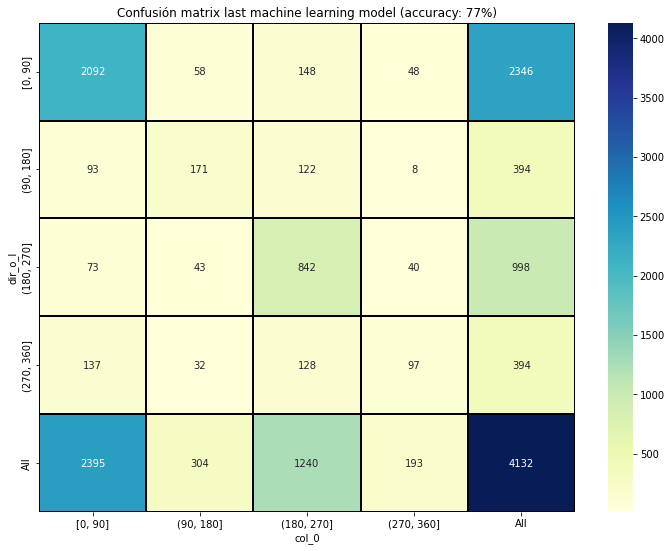

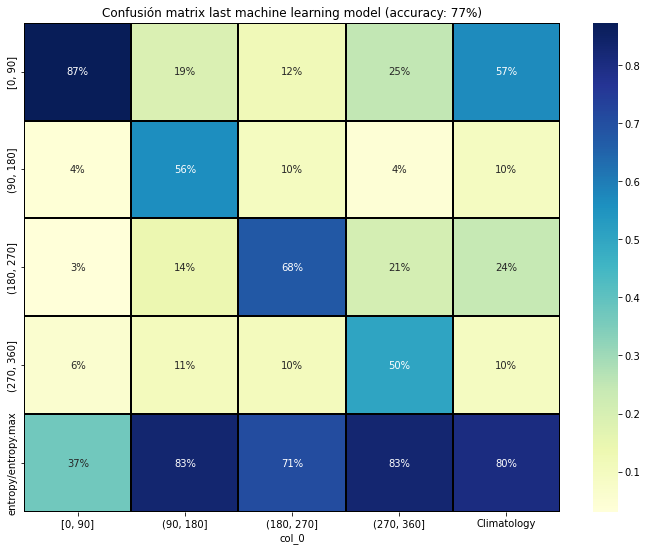

In [84]:
plt.figure(figsize=(12, 9))
plt.title("Confusión matrix last machine learning model (accuracy: {:.0%})".format(acc_t[-1]))
global_sc_ml = pd.crosstab(y_test, y_pred, margins=True,)
sns.heatmap(global_sc_ml[global_sc.columns],annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');


plt.figure(figsize=(12, 9))
plt.title("Confusión matrix last machine learning model (accuracy: {:.0%})".format(acc_t[-1]))
column_sc_ml = pd.crosstab(y_test, y_pred, margins=True,normalize="columns")
column_sc_ml = column_sc_ml.append(pd.DataFrame(entropy(column_sc_ml,base=2)/(math.log2(column_sc_ml.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc_ml.columns).T).rename(columns={"All":"Climatology"})
sns.heatmap(column_sc_ml[column_sc.columns],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

**Save algorithm**

In [ ]:
import pickle
from sklearn.pipeline import Pipeline


estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)
print(pipe)
al_file={"x_var":X.columns,"coor":coor,"pipe":pipe}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/Coron/algorithms/dir_coron_d0.al", 'wb'))

Pipeline(steps=[('ml_model', LGBMClassifier(n_estimators=200))])
